Used data instead of ms_data_train in train loader creation

TODO: possible increase learning rate

### \\\ Currently used ///

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
# use multiple GPUs
gpu = 5
multi_gpus = None#[0, 1, 2]
b = 4
zero_one_normalize = False
zoom = 0.525

dtype = np.float64

In [7]:
# load mask
mask = None

In [8]:
train_h5 = h5py.File('/analysis/ritter/data/MS/CIS/train_dataset.h5', 'r')
holdout_h5 = h5py.File('/analysis/ritter/data/MS/CIS/holdout_dataset.h5', 'r')

In [9]:
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']
X_train, y_train = train_h5['X'], train_h5['y']

In [10]:
# convert data to numpy arrays
#X_train = np.array(X_train, dtype=dtype)
#y_train = np.array(y_train)

#X_holdout = np.array(X_holdout, dtype=dtype)
#y_holdout = np.array(y_holdout)

In [11]:
class MSDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=zoom, dtype=np.float32):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = zoom
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
        #if self.target_transform:
        #    label = self.target_transform(label)
            
        sample = {"image" : image,
                 "label" : label}
                 #"idx":idx}
        return sample

In [12]:
if zero_one_normalize:
    intensity = IntensityRescale()
    ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
    ms_data_test = MSDataset(X_holdout, y_holdout, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
else:
    ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
    ms_data_test = MSDataset(X_holdout, y_holdout, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)

In [13]:
sample = ms_data_train[29]
img = sample["image"]

In [14]:
img.shape

torch.Size([1, 96, 114, 96])

Text(0.5, 1.0, '1.0')

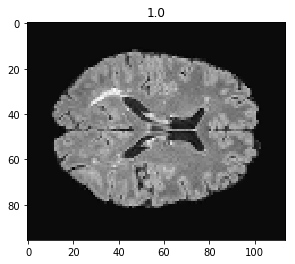

In [15]:
plt.imshow(img[0][:,:,46], cmap='gray')
plt.title(sample["label"].item())

# Define the classifier

In [16]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)

        # 4, 64, 1, 2, 1
        self.classifier_scratch = nn.Sequential(
            nn.Linear(128, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = F.dropout3d(self.pool_1(x), p=self.drp_rate)
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = F.dropout3d(self.pool_2(x), p=self.drp_rate)
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        h = F.dropout3d(self.pool_4(x), p=self.drp_rate)
        if print_size:
            print(h.shape)    
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [17]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [18]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 333889


# Training

In [19]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      

    #kf = StratifiedKFold(n_splits=k_folds, shuffle=True)
    #kf = KFold(n_splits=k_folds, shuffle=True)
    all_indices = list(range(len(data)))
    train_idx, val_idx = train_test_split(all_indices, test_size=0.1, random_state=12)
    fold_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    #for train_idx, val_idx in kf.split(data):#, df["label"]):
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        print("Shuffled the data..")

        # Note: is the dataset loading necessary again?
        if zero_one_normalize:
            intensity = IntensityRescale()
            ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
        else:
            ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
        
        train_loader = DataLoader(
            ms_data_train, batch_size=b, num_workers=4, sampler=train_sampler
        )
        val_loader = DataLoader(
            ms_data_train, batch_size=1, num_workers=1, sampler=val_sampler
        )

        sample = next(iter(train_loader))
        img = sample["image"][0]
        lbl = sample["label"][0]
        print(img.shape)
        print(len(train_loader))
        plt.imshow(img.squeeze()[:,:,48], cmap='gray')
        plt.title(lbl.item())
        plt.show()
        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu,
            #scheduler=sched,
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=20,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    return fold_metric, models


In [20]:
num_epochs = 200
min_iters = 3
ignore_epochs = 5
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [21]:
#r = 0

In [22]:
#output_dir = "/analysis/fabiane/models/MS/pretrained/from_keras/pytorch_finetuned/hdf5"
# ModelCheckpoint(path=output_dir,
                             #prepend="repeat_{}".format(r),
                             #store_best=True,
                             #ignore_before=ignore_epochs,
                             #retain_metric=retain_metric),

#augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [23]:
callbacks = [EarlyStopping(patience=16, ignore_before=ignore_epochs, retain_metric="loss", mode='min')]
#callbacks = []

Starting trial 0
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


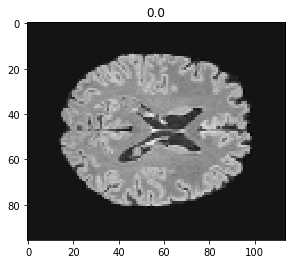

[0,    20] loss: 0.70668
Time elapsed: 0h:0m:4s
train accuracy_score: 47.75 %
train balanced_accuracy: 46.97 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.744674
[1,    20] loss: 0.69997
Time elapsed: 0h:0m:8s
train accuracy_score: 49.55 %
train balanced_accuracy: 46.61 %
val accuracy_score: 30.77 %
val balanced_accuracy: 43.06 %
Val loss: 0.721694
[2,    20] loss: 0.69455
Time elapsed: 0h:0m:13s
train accuracy_score: 55.86 %
train balanced_accuracy: 52.88 %
val accuracy_score: 53.85 %
val balanced_accuracy: 45.83 %
Val loss: 0.688750
[3,    20] loss: 0.70762
Time elapsed: 0h:0m:17s
train accuracy_score: 42.34 %
train balanced_accuracy: 42.11 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.718400
[4,    20] loss: 0.69521
Time elapsed: 0h:0m:22s
train accuracy_score: 51.35 %
train balanced_accuracy: 48.53 %
val accuracy_score: 53.85 %
val balanced_accuracy: 59.72 %
Val loss: 0.702168
[5,    20] loss: 0.69783
Time elapsed: 0h:0m:26s
tra

[43,    20] loss: 0.50373
Time elapsed: 0h:4m:24s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.45 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.521722
[44,    20] loss: 0.54898
Time elapsed: 0h:4m:28s
train accuracy_score: 72.07 %
train balanced_accuracy: 72.02 %
val accuracy_score: 61.54 %
val balanced_accuracy: 65.28 %
Val loss: 0.512030
[45,    20] loss: 0.49323
Time elapsed: 0h:4m:33s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.75 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.453023
[46,    20] loss: 0.47870
Time elapsed: 0h:4m:43s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.71 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.722923
[47,    20] loss: 0.45872
Time elapsed: 0h:4m:51s
train accuracy_score: 76.58 %
train balanced_accuracy: 75.91 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.511684
[48,    20] loss: 0.50367
Time elapsed: 0h:5m

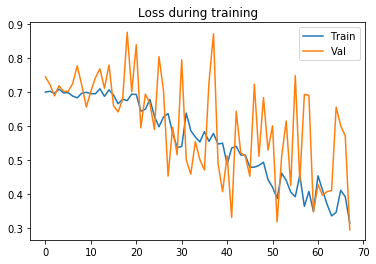

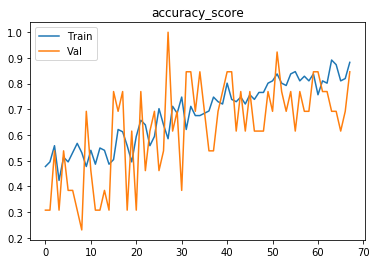

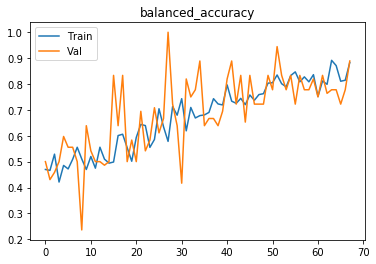

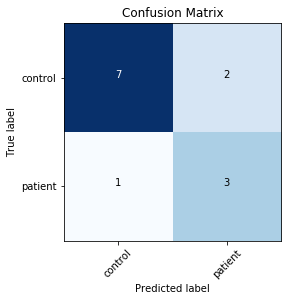

Starting trial 1
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


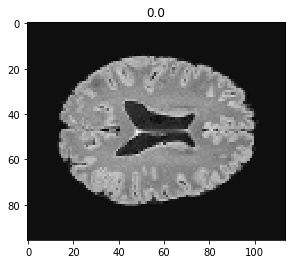

[0,    20] loss: 0.70240
Time elapsed: 0h:0m:4s
train accuracy_score: 54.95 %
train balanced_accuracy: 53.52 %
val accuracy_score: 46.15 %
val balanced_accuracy: 33.33 %
Val loss: 0.678127
[1,    20] loss: 0.68672
Time elapsed: 0h:0m:8s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.90 %
val accuracy_score: 30.77 %
val balanced_accuracy: 43.06 %
Val loss: 0.752325
[2,    20] loss: 0.69942
Time elapsed: 0h:0m:14s
train accuracy_score: 48.65 %
train balanced_accuracy: 45.76 %
val accuracy_score: 46.15 %
val balanced_accuracy: 47.22 %
Val loss: 0.701471
[3,    20] loss: 0.70140
Time elapsed: 0h:0m:19s
train accuracy_score: 43.24 %
train balanced_accuracy: 43.99 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.723074
[4,    20] loss: 0.69098
Time elapsed: 0h:0m:23s
train accuracy_score: 52.25 %
train balanced_accuracy: 49.49 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.717343
[5,    20] loss: 0.69456
Time elapsed: 0h:0m:29s
tra

[43,    20] loss: 0.47314
Time elapsed: 0h:3m:32s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.99 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.347421
[44,    20] loss: 0.47272
Time elapsed: 0h:3m:36s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.09 %
val accuracy_score: 61.54 %
val balanced_accuracy: 65.28 %
Val loss: 0.591715
[45,    20] loss: 0.46843
Time elapsed: 0h:3m:41s
train accuracy_score: 80.18 %
train balanced_accuracy: 80.44 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.844881
[46,    20] loss: 0.48131
Time elapsed: 0h:3m:46s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.45 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.682679
[47,    20] loss: 0.51707
Time elapsed: 0h:3m:51s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.14 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.459664
[48,    20] loss: 0.43571
Time elapsed: 0h:

[86,    20] loss: 0.12725
Time elapsed: 0h:7m:4s
train accuracy_score: 95.50 %
train balanced_accuracy: 95.53 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.206267
[87,    20] loss: 0.15169
Time elapsed: 0h:7m:9s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.31 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.320121
Early stopping in epoch 88
Total time elapsed: 0h:7m:10s
Finished fold.


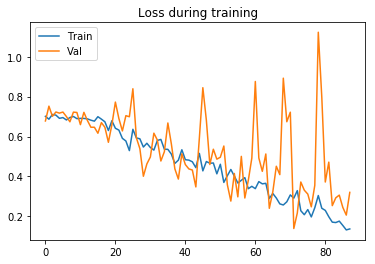

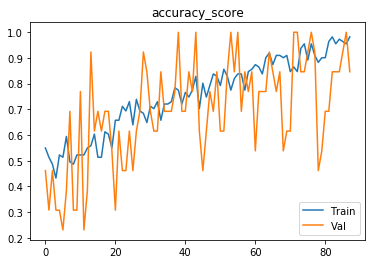

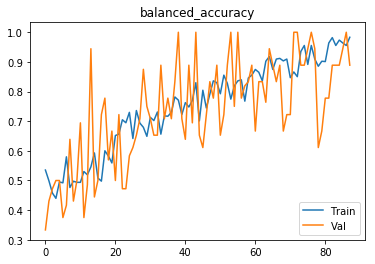

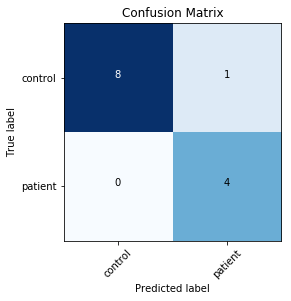

Starting trial 2
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


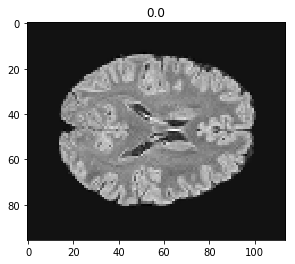

[0,    20] loss: 0.70481
Time elapsed: 0h:0m:4s
train accuracy_score: 51.35 %
train balanced_accuracy: 48.88 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.39 %
Val loss: 0.675125
[1,    20] loss: 0.69777
Time elapsed: 0h:0m:8s
train accuracy_score: 39.64 %
train balanced_accuracy: 39.57 %
val accuracy_score: 38.46 %
val balanced_accuracy: 48.61 %
Val loss: 0.726605
[2,    20] loss: 0.69030
Time elapsed: 0h:0m:21s
train accuracy_score: 54.95 %
train balanced_accuracy: 52.72 %
val accuracy_score: 38.46 %
val balanced_accuracy: 55.56 %
Val loss: 0.709112
[3,    20] loss: 0.69975
Time elapsed: 0h:0m:28s
train accuracy_score: 47.75 %
train balanced_accuracy: 46.28 %
val accuracy_score: 23.08 %
val balanced_accuracy: 23.61 %
Val loss: 0.711855
[4,    20] loss: 0.68962
Time elapsed: 0h:0m:36s
train accuracy_score: 56.76 %
train balanced_accuracy: 56.81 %
val accuracy_score: 30.77 %
val balanced_accuracy: 36.11 %
Val loss: 0.714990
[5,    20] loss: 0.72058
Time elapsed: 0h:0m:42s
tra

[43,    20] loss: 0.52862
Time elapsed: 0h:3m:56s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.37 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.83 %
Val loss: 0.497411
[44,    20] loss: 0.47877
Time elapsed: 0h:4m:1s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.25 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.588820
[45,    20] loss: 0.54038
Time elapsed: 0h:4m:5s
train accuracy_score: 72.97 %
train balanced_accuracy: 72.41 %
val accuracy_score: 84.62 %
val balanced_accuracy: 75.00 %
Val loss: 0.406069
[46,    20] loss: 0.51731
Time elapsed: 0h:4m:10s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.03 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.366760
[47,    20] loss: 0.45297
Time elapsed: 0h:4m:15s
train accuracy_score: 81.98 %
train balanced_accuracy: 81.91 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.581124
[48,    20] loss: 0.47167
Time elapsed: 0h:4m:1

[86,    20] loss: 0.13535
Time elapsed: 0h:7m:56s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.50 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.474505
[87,    20] loss: 0.10832
Time elapsed: 0h:8m:4s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.19 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.522433
[88,    20] loss: 0.11431
Time elapsed: 0h:8m:13s
train accuracy_score: 94.59 %
train balanced_accuracy: 94.57 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.83 %
Val loss: 0.447870
[89,    20] loss: 0.07911
Time elapsed: 0h:8m:25s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.388126
[90,    20] loss: 0.11644
Time elapsed: 0h:8m:41s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.34 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.710077
[91,    20] loss: 0.12721
Time elapsed: 0h:8m:

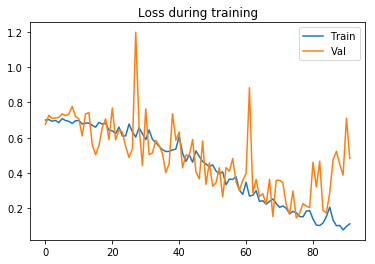

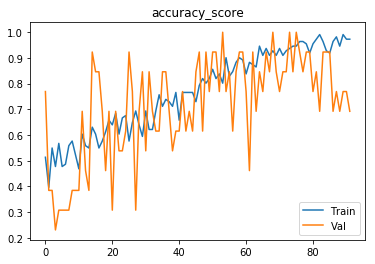

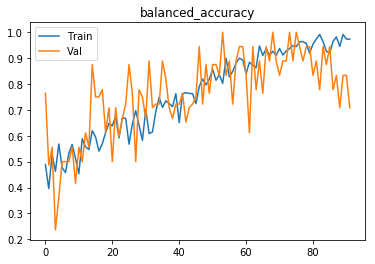

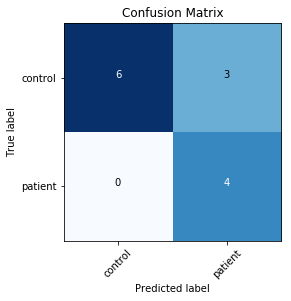

Starting trial 3
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


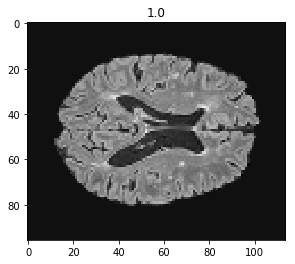

[0,    20] loss: 0.69815
Time elapsed: 0h:0m:4s
train accuracy_score: 45.05 %
train balanced_accuracy: 42.83 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.717835
[1,    20] loss: 0.69628
Time elapsed: 0h:0m:8s
train accuracy_score: 51.35 %
train balanced_accuracy: 50.59 %
val accuracy_score: 46.15 %
val balanced_accuracy: 54.17 %
Val loss: 0.702956
[2,    20] loss: 0.70806
Time elapsed: 0h:0m:13s
train accuracy_score: 51.35 %
train balanced_accuracy: 48.99 %
val accuracy_score: 38.46 %
val balanced_accuracy: 55.56 %
Val loss: 0.698610
[3,    20] loss: 0.68703
Time elapsed: 0h:0m:17s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.741566
[4,    20] loss: 0.68939
Time elapsed: 0h:0m:22s
train accuracy_score: 49.55 %
train balanced_accuracy: 47.64 %
val accuracy_score: 46.15 %
val balanced_accuracy: 47.22 %
Val loss: 0.688214
[5,    20] loss: 0.69467
Time elapsed: 0h:0m:26s
tra

[43,    20] loss: 0.50318
Time elapsed: 0h:3m:34s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.33 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.810401
[44,    20] loss: 0.43646
Time elapsed: 0h:3m:38s
train accuracy_score: 80.18 %
train balanced_accuracy: 79.76 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.464381
[45,    20] loss: 0.40285
Time elapsed: 0h:3m:43s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.10 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.509882
[46,    20] loss: 0.39301
Time elapsed: 0h:3m:47s
train accuracy_score: 83.78 %
train balanced_accuracy: 83.60 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.528978
[47,    20] loss: 0.44334
Time elapsed: 0h:3m:52s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.22 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.713113
[48,    20] loss: 0.42979
Time elapsed: 0h:3m

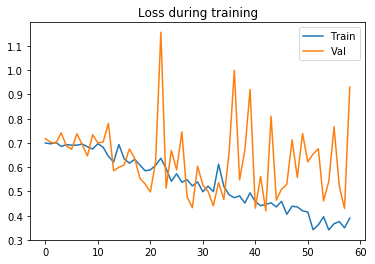

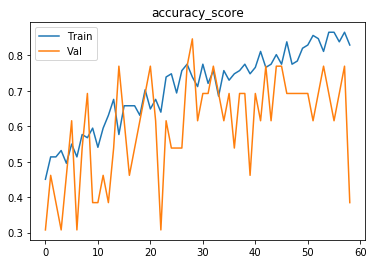

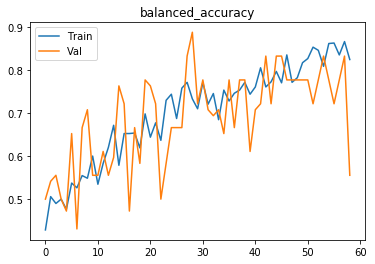

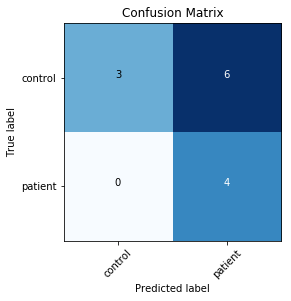

Starting trial 4
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


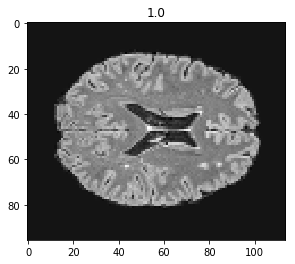

[0,    20] loss: 0.70541
Time elapsed: 0h:0m:4s
train accuracy_score: 33.33 %
train balanced_accuracy: 33.18 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.83 %
Val loss: 0.686303
[1,    20] loss: 0.69089
Time elapsed: 0h:0m:8s
train accuracy_score: 51.35 %
train balanced_accuracy: 48.42 %
val accuracy_score: 53.85 %
val balanced_accuracy: 66.67 %
Val loss: 0.690602
[2,    20] loss: 0.69045
Time elapsed: 0h:0m:13s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.45 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.737212
[3,    20] loss: 0.69539
Time elapsed: 0h:0m:18s
train accuracy_score: 49.55 %
train balanced_accuracy: 47.07 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.723459
[4,    20] loss: 0.69660
Time elapsed: 0h:0m:22s
train accuracy_score: 46.85 %
train balanced_accuracy: 45.21 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.697486
[5,    20] loss: 0.68995
Time elapsed: 0h:0m:27s
tra

[43,    20] loss: 0.41551
Time elapsed: 0h:3m:48s
train accuracy_score: 81.08 %
train balanced_accuracy: 81.18 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.470270
[44,    20] loss: 0.41242
Time elapsed: 0h:3m:59s
train accuracy_score: 81.98 %
train balanced_accuracy: 81.80 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.539947
[45,    20] loss: 0.38508
Time elapsed: 0h:4m:9s
train accuracy_score: 83.78 %
train balanced_accuracy: 83.49 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.331022
[46,    20] loss: 0.35885
Time elapsed: 0h:4m:13s
train accuracy_score: 91.89 %
train balanced_accuracy: 91.92 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.614280
[47,    20] loss: 0.40637
Time elapsed: 0h:4m:18s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.53 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.355246
[48,    20] loss: 0.44008
Time elapsed: 0h:4m:

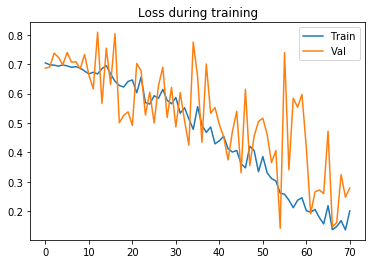

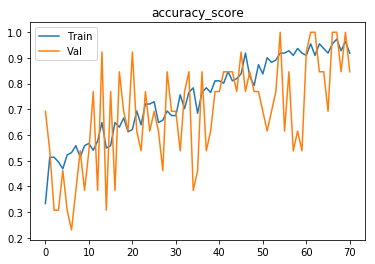

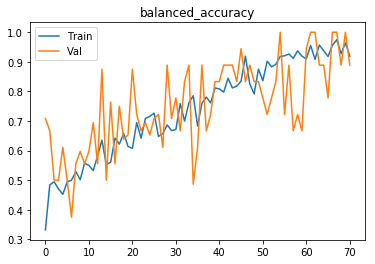

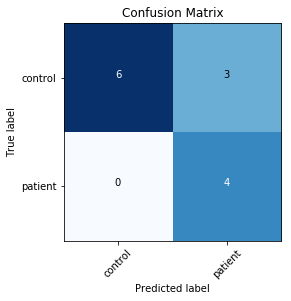

Starting trial 5
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


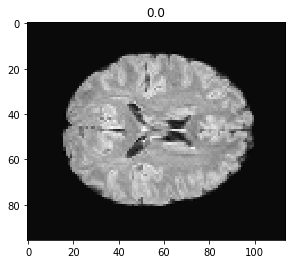

[0,    20] loss: 0.69514
Time elapsed: 0h:0m:4s
train accuracy_score: 48.65 %
train balanced_accuracy: 46.33 %
val accuracy_score: 38.46 %
val balanced_accuracy: 55.56 %
Val loss: 0.704006
[1,    20] loss: 0.68146
Time elapsed: 0h:0m:8s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.34 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.726448
[2,    20] loss: 0.68511
Time elapsed: 0h:0m:13s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.11 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.695291
[3,    20] loss: 0.70101
Time elapsed: 0h:0m:18s
train accuracy_score: 53.15 %
train balanced_accuracy: 51.94 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.679330
[4,    20] loss: 0.70656
Time elapsed: 0h:0m:24s
train accuracy_score: 49.55 %
train balanced_accuracy: 49.35 %
val accuracy_score: 46.15 %
val balanced_accuracy: 54.17 %
Val loss: 0.699173
[5,    20] loss: 0.68967
Time elapsed: 0h:0m:34s
tra

[43,    20] loss: 0.48011
Time elapsed: 0h:3m:35s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.10 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.460487
[44,    20] loss: 0.50969
Time elapsed: 0h:3m:40s
train accuracy_score: 78.38 %
train balanced_accuracy: 77.72 %
val accuracy_score: 92.31 %
val balanced_accuracy: 87.50 %
Val loss: 0.263270
[45,    20] loss: 0.39402
Time elapsed: 0h:3m:44s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.75 %
val accuracy_score: 61.54 %
val balanced_accuracy: 72.22 %
Val loss: 0.786910
[46,    20] loss: 0.44771
Time elapsed: 0h:3m:49s
train accuracy_score: 77.48 %
train balanced_accuracy: 76.87 %
val accuracy_score: 69.23 %
val balanced_accuracy: 63.89 %
Val loss: 0.474060
[47,    20] loss: 0.45820
Time elapsed: 0h:3m:53s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.67 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.461266
[48,    20] loss: 0.47711
Time elapsed: 0h:3m

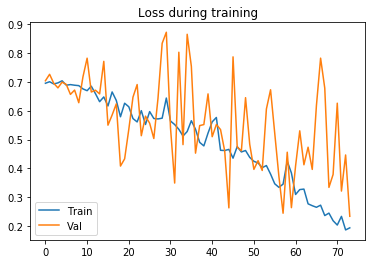

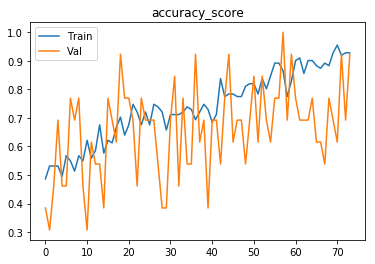

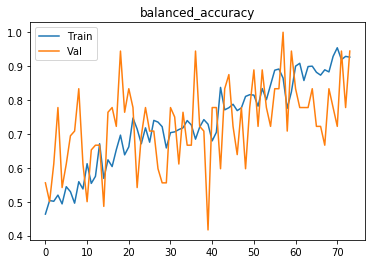

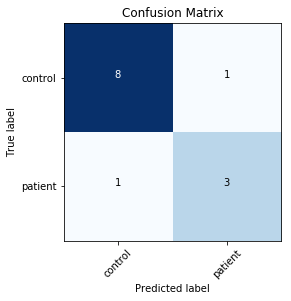

Starting trial 6
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


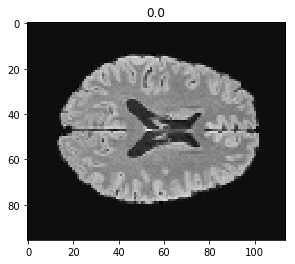

[0,    20] loss: 0.69503
Time elapsed: 0h:0m:4s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.57 %
val accuracy_score: 53.85 %
val balanced_accuracy: 59.72 %
Val loss: 0.697066
[1,    20] loss: 0.69726
Time elapsed: 0h:0m:8s
train accuracy_score: 48.65 %
train balanced_accuracy: 46.22 %
val accuracy_score: 38.46 %
val balanced_accuracy: 48.61 %
Val loss: 0.704275
[2,    20] loss: 0.70275
Time elapsed: 0h:0m:13s
train accuracy_score: 45.95 %
train balanced_accuracy: 46.41 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.741263
[3,    20] loss: 0.70288
Time elapsed: 0h:0m:18s
train accuracy_score: 45.95 %
train balanced_accuracy: 43.90 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.39 %
Val loss: 0.678195
[4,    20] loss: 0.69317
Time elapsed: 0h:0m:22s
train accuracy_score: 54.95 %
train balanced_accuracy: 52.72 %
val accuracy_score: 23.08 %
val balanced_accuracy: 37.50 %
Val loss: 0.712728
[5,    20] loss: 0.70074
Time elapsed: 0h:0m:27s
tra

[43,    20] loss: 0.47120
Time elapsed: 0h:3m:27s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.64 %
val accuracy_score: 84.62 %
val balanced_accuracy: 81.94 %
Val loss: 0.397616
[44,    20] loss: 0.37369
Time elapsed: 0h:3m:32s
train accuracy_score: 81.98 %
train balanced_accuracy: 81.91 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.472302
[45,    20] loss: 0.43083
Time elapsed: 0h:3m:36s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.06 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.83 %
Val loss: 0.438827
[46,    20] loss: 0.40990
Time elapsed: 0h:3m:41s
train accuracy_score: 81.08 %
train balanced_accuracy: 81.18 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.356457
[47,    20] loss: 0.38430
Time elapsed: 0h:3m:51s
train accuracy_score: 85.59 %
train balanced_accuracy: 85.41 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.470360
[48,    20] loss: 0.41359
Time elapsed: 0h:3m

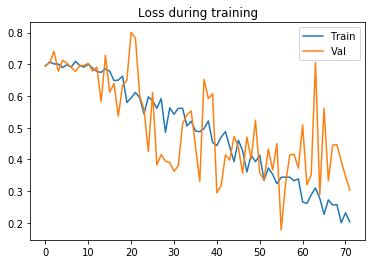

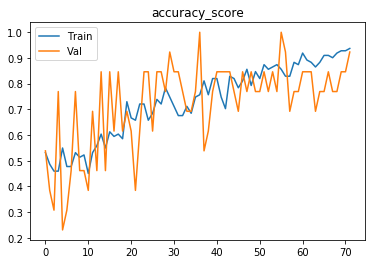

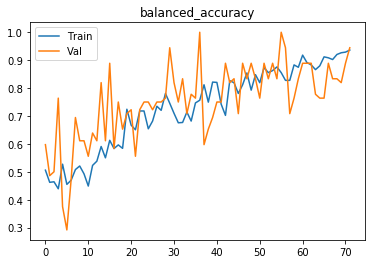

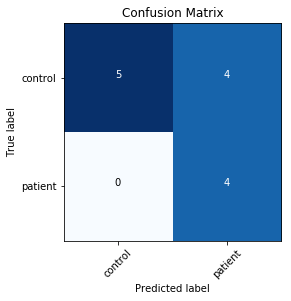

Starting trial 7
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


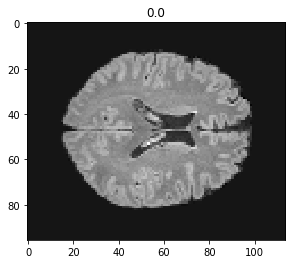

[0,    20] loss: 0.69612
Time elapsed: 0h:0m:27s
train accuracy_score: 48.65 %
train balanced_accuracy: 45.88 %
val accuracy_score: 23.08 %
val balanced_accuracy: 37.50 %
Val loss: 0.714363
[1,    20] loss: 0.69267
Time elapsed: 0h:0m:31s
train accuracy_score: 45.95 %
train balanced_accuracy: 45.16 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.708763
[2,    20] loss: 0.69481
Time elapsed: 0h:0m:36s
train accuracy_score: 55.86 %
train balanced_accuracy: 52.88 %
val accuracy_score: 53.85 %
val balanced_accuracy: 66.67 %
Val loss: 0.701851
[3,    20] loss: 0.72415
Time elapsed: 0h:0m:41s
train accuracy_score: 45.95 %
train balanced_accuracy: 47.56 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.735023
[4,    20] loss: 0.70618
Time elapsed: 0h:0m:45s
train accuracy_score: 54.05 %
train balanced_accuracy: 51.08 %
val accuracy_score: 53.85 %
val balanced_accuracy: 45.83 %
Val loss: 0.686547
[5,    20] loss: 0.69575
Time elapsed: 0h:0m:50s
t

[43,    20] loss: 0.50605
Time elapsed: 0h:3m:58s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.79 %
val accuracy_score: 92.31 %
val balanced_accuracy: 87.50 %
Val loss: 0.382084
[44,    20] loss: 0.44383
Time elapsed: 0h:4m:3s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.33 %
val accuracy_score: 92.31 %
val balanced_accuracy: 87.50 %
Val loss: 0.354887
[45,    20] loss: 0.47342
Time elapsed: 0h:4m:7s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.44 %
val accuracy_score: 46.15 %
val balanced_accuracy: 61.11 %
Val loss: 0.769361
[46,    20] loss: 0.43068
Time elapsed: 0h:4m:12s
train accuracy_score: 72.97 %
train balanced_accuracy: 71.95 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.383852
[47,    20] loss: 0.48327
Time elapsed: 0h:4m:17s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.63 %
val accuracy_score: 53.85 %
val balanced_accuracy: 66.67 %
Val loss: 0.697536
[48,    20] loss: 0.41765
Time elapsed: 0h:4m:2

[86,    20] loss: 0.09409
Time elapsed: 0h:7m:38s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.19 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.151195
[87,    20] loss: 0.07163
Time elapsed: 0h:7m:43s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.19 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.398750
[88,    20] loss: 0.06426
Time elapsed: 0h:7m:47s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.04 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.295278
[89,    20] loss: 0.05650
Time elapsed: 0h:7m:52s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.477270
[90,    20] loss: 0.04787
Time elapsed: 0h:7m:58s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.284551
[91,    20] loss: 0.05356
Time elapsed:

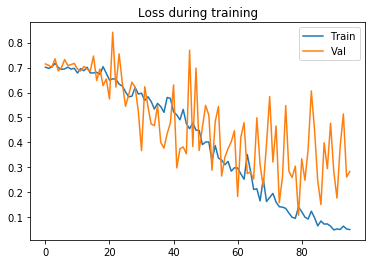

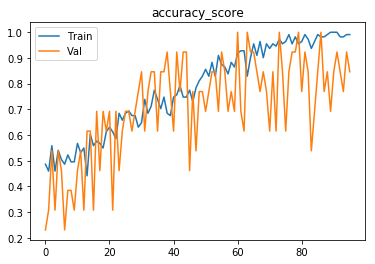

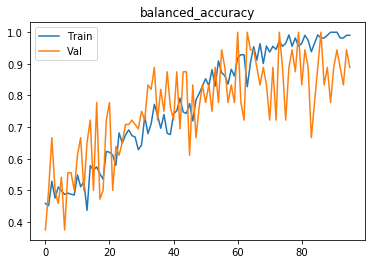

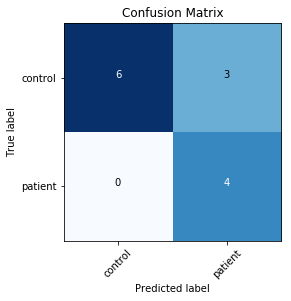

Starting trial 8
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


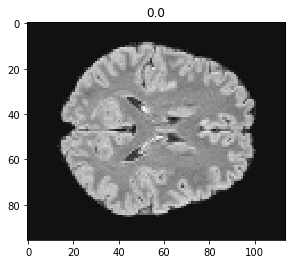

[0,    20] loss: 0.70332
Time elapsed: 0h:0m:4s
train accuracy_score: 52.25 %
train balanced_accuracy: 52.69 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.713422
[1,    20] loss: 0.70307
Time elapsed: 0h:0m:8s
train accuracy_score: 47.75 %
train balanced_accuracy: 45.26 %
val accuracy_score: 38.46 %
val balanced_accuracy: 48.61 %
Val loss: 0.708822
[2,    20] loss: 0.67571
Time elapsed: 0h:0m:13s
train accuracy_score: 56.76 %
train balanced_accuracy: 53.85 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.710006
[3,    20] loss: 0.69571
Time elapsed: 0h:0m:18s
train accuracy_score: 54.95 %
train balanced_accuracy: 52.72 %
val accuracy_score: 53.85 %
val balanced_accuracy: 66.67 %
Val loss: 0.697161
[4,    20] loss: 0.69538
Time elapsed: 0h:0m:22s
train accuracy_score: 54.95 %
train balanced_accuracy: 55.23 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.751142
[5,    20] loss: 0.66826
Time elapsed: 0h:0m:27s
tra

[43,    20] loss: 0.41406
Time elapsed: 0h:4m:20s
train accuracy_score: 81.98 %
train balanced_accuracy: 82.14 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.524785
[44,    20] loss: 0.39391
Time elapsed: 0h:4m:25s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.18 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.427931
[45,    20] loss: 0.46787
Time elapsed: 0h:4m:30s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.44 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.433453
[46,    20] loss: 0.49481
Time elapsed: 0h:4m:34s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.60 %
val accuracy_score: 84.62 %
val balanced_accuracy: 75.00 %
Val loss: 0.411100
[47,    20] loss: 0.39648
Time elapsed: 0h:4m:39s
train accuracy_score: 84.68 %
train balanced_accuracy: 84.79 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.395622
[48,    20] loss: 0.36996
Time elapsed: 0h:4m

[86,    20] loss: 0.13188
Time elapsed: 0h:7m:53s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.50 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.232419
[87,    20] loss: 0.12647
Time elapsed: 0h:7m:58s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.04 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.234963
[88,    20] loss: 0.10962
Time elapsed: 0h:8m:3s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.34 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.323270
[89,    20] loss: 0.06240
Time elapsed: 0h:8m:7s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.15 %
val accuracy_score: 92.31 %
val balanced_accuracy: 94.44 %
Val loss: 0.284350
[90,    20] loss: 0.12628
Time elapsed: 0h:8m:12s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.46 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.369637
Early stopping in epoch 91
Total time elapsed: 

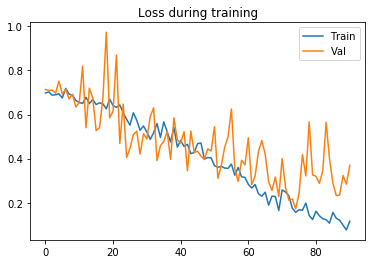

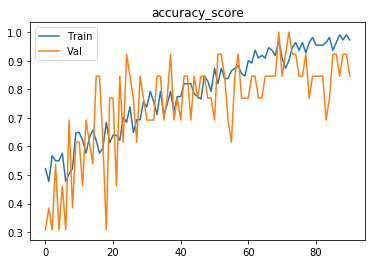

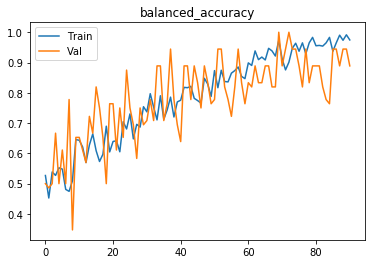

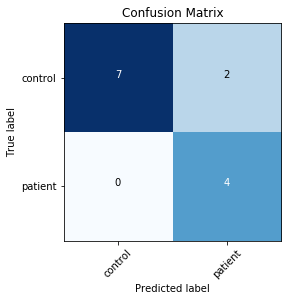

Starting trial 9
Shuffled the data..
torch.Size([1, 96, 114, 96])
28


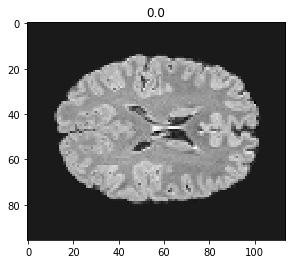

[0,    20] loss: 0.69620
Time elapsed: 0h:0m:4s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.07 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.715215
[1,    20] loss: 0.70607
Time elapsed: 0h:0m:8s
train accuracy_score: 45.95 %
train balanced_accuracy: 44.70 %
val accuracy_score: 30.77 %
val balanced_accuracy: 50.00 %
Val loss: 0.727016
[2,    20] loss: 0.69215
Time elapsed: 0h:0m:13s
train accuracy_score: 49.55 %
train balanced_accuracy: 46.95 %
val accuracy_score: 38.46 %
val balanced_accuracy: 55.56 %
Val loss: 0.715216
[3,    20] loss: 0.69875
Time elapsed: 0h:0m:18s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.68 %
val accuracy_score: 46.15 %
val balanced_accuracy: 33.33 %
Val loss: 0.701668
[4,    20] loss: 0.69792
Time elapsed: 0h:0m:22s
train accuracy_score: 44.14 %
train balanced_accuracy: 43.92 %
val accuracy_score: 23.08 %
val balanced_accuracy: 37.50 %
Val loss: 0.721128
[5,    20] loss: 0.70511
Time elapsed: 0h:0m:27s
tra

[43,    20] loss: 0.51565
Time elapsed: 0h:4m:0s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.41 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.511626
[44,    20] loss: 0.49784
Time elapsed: 0h:4m:10s
train accuracy_score: 80.18 %
train balanced_accuracy: 79.99 %
val accuracy_score: 84.62 %
val balanced_accuracy: 81.94 %
Val loss: 0.470145
[45,    20] loss: 0.47856
Time elapsed: 0h:4m:21s
train accuracy_score: 80.18 %
train balanced_accuracy: 79.99 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.499428
[46,    20] loss: 0.47389
Time elapsed: 0h:4m:31s
train accuracy_score: 72.07 %
train balanced_accuracy: 71.79 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.527763
[47,    20] loss: 0.45470
Time elapsed: 0h:4m:36s
train accuracy_score: 77.48 %
train balanced_accuracy: 76.99 %
val accuracy_score: 92.31 %
val balanced_accuracy: 87.50 %
Val loss: 0.372312
[48,    20] loss: 0.43766
Time elapsed: 0h:4m:

[86,    20] loss: 0.12538
Time elapsed: 0h:7m:35s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.31 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.288566
[87,    20] loss: 0.11039
Time elapsed: 0h:7m:40s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.34 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.291277
[88,    20] loss: 0.10299
Time elapsed: 0h:7m:45s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.31 %
val accuracy_score: 69.23 %
val balanced_accuracy: 77.78 %
Val loss: 0.595524
[89,    20] loss: 0.14568
Time elapsed: 0h:7m:49s
train accuracy_score: 94.59 %
train balanced_accuracy: 94.69 %
val accuracy_score: 84.62 %
val balanced_accuracy: 88.89 %
Val loss: 0.312024
[90,    20] loss: 0.09555
Time elapsed: 0h:7m:54s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.19 %
val accuracy_score: 76.92 %
val balanced_accuracy: 83.33 %
Val loss: 0.387688
[91,    20] loss: 0.10980
Time elapsed: 0h:7m

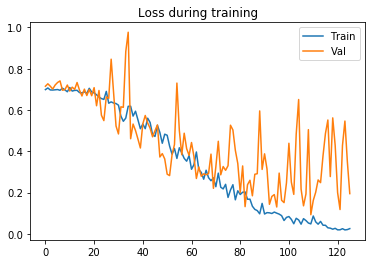

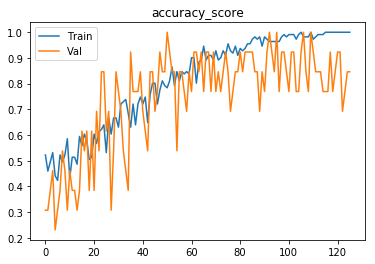

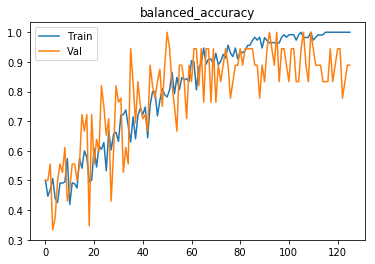

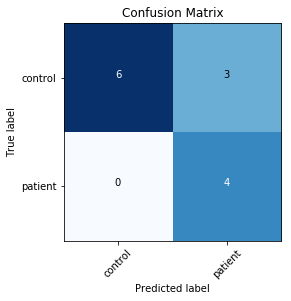

################################
################################
All accuracies: [0.8888888888888888, 0.8888888888888888, 0.7083333333333333, 0.5555555555555556, 0.8888888888888888, 0.9444444444444444, 0.9444444444444444, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888]
0.8486111111111111
0.1156119653980931


In [24]:
fold_metric, models = run(net=net, data=ms_data_train,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [25]:
5/0

ZeroDivisionError: division by zero

# Start inference

In [26]:
test_loader = DataLoader(
            ms_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [27]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model in enumerate(models):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    
    net = model.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    #print(all_preds)
    #print(all_labels)
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    '''trainer = Trainer(
                net,
                criterion,
                optimizer,
                scheduler=None,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="binary"
            )
    computed_metrics = trainer.evaluate_model(test_loader, metrics=[balanced_accuracy])'''
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))


Fold 0
0.7346153846153847
Fold 1
0.7230769230769231
Fold 2
0.85
Fold 3
0.65
Fold 4
0.7615384615384615
Fold 5
0.8115384615384615
Fold 6
0.6730769230769231
Fold 7
0.75
Fold 8
0.8
Fold 9
0.75
######## Final results ########
          0
0  0.734615
1  0.723077
2  0.850000
3  0.650000
4  0.761538
5  0.811538
6  0.673077
7  0.750000
8  0.800000
9  0.750000
Balanced accuracy mean 75.04 %


In [ ]:

# load holdout set
df = pd.read_csv(doc_dir)
df = df.loc[indices_holdout]

metrics = []
callbacks = []

criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0)

if zero_one_normalize:
    test_transforms = transforms.Compose([intensity, ToTensor()])
else:
    test_transforms = transforms.Compose([ToTensor()])
    
cis_data_test = CISDataset(X_holdout, y_holdout, transform=test_transforms, mask=mask, dtype=dtype)
test_loader = DataLoader(
    cis_data_test, batch_size=4, num_workers=2, shuffle=True
        )

In [ ]:
cis_data[4]["image"].dtype

In [ ]:
next(iter(test_loader))["image"].dtype

In [ ]:
model_dirs = [os.path.join(output_dir, "repeat_0_cv_fold_6_training_epoch_28_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_5_training_epoch_87_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_4_training_epoch_30_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_3_training_epoch_40_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_2_training_epoch_30_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_1_training_epoch_25_FINAL.h5"),
os.path.join(output_dir, "repeat_0_cv_fold_0_training_epoch_32_FINAL.h5")]

In [ ]:
model_dirs = [os.path.join(output_dir,"repeat_0_cv_fold_{}_BEST_ITERATION.h5".format(i)) for i in range(7)]
metrics = []
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))
    
    # load pre-trained model
    #net = SixtyFourNet().cuda(gpu)
    net = serialize_model(net, model_dir)

    trainer = Trainer(
                net,
                criterion,
                optimizer,
                scheduler=None,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="binary"
            )
    computed_metrics = trainer.evaluate_model(test_loader, metrics=[balanced_accuracy])
    
    metrics.append(computed_metrics)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df["balanced_accuracy"])*100))


In [ ]:
for i, m in enumerate(models):
    print(i)
    for param in m.parameters():
        print(param.grad.norm(2))

In [ ]:
all_weight_norms = {}
all_bias_norms = {}
for i, m in enumerate(models):
    bias_norms = {}
    weight_norms = {}
    print(i)
    for name, param in m.named_parameters():
        #norms.append(param.grad.norm(2))
        norm = param.grad.norm(2)
        if name.endswith("bias"):
            name = name.replace(".bias", "")
            bias_norms["layer_{}".format(name)] = norm
        elif name.endswith("weight"):
            name = name.replace(".weight", "")
            weight_norms["layer_{}".format(name)] = norm
    all_weight_norms["fold_{}".format(i)] = weight_norms
    all_bias_norms["fold_{}".format(i)] = bias_norms

In [ ]:
list(metrics_df["balanced_accuracy"])

In [ ]:
num_cols = 2
num_rows = 4
plt.figure()
c = 1
r = 1

plt.figure(figsize=(12, 24))
plt.subplots_adjust(hspace=0.9, wspace=0.2)
for f in range(len(models)):
    plt.subplot(num_rows, num_cols, f+1)
    plt.plot(*zip(*sorted(all_weight_norms["fold_{}".format(f)].items())))
    plt.plot(*zip(*sorted(all_bias_norms["fold_{}".format(f)].items())))
    plt.legend(["Weights", "Biases"])
    plt.title("Fold {} Test balanced acc {:.2f}".format(f, metrics_df["balanced_accuracy"][f]))
    plt.xticks(rotation=90)
    axes = plt.gca()
    axes.set_ylim([0, 1])
    c += 1
plt.show()
    